# EDA 

### Import Essential Libraries and Dataset

In [47]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [48]:
# import dataset
df_people = pd.read_csv('data\\people.csv')
df_sim = pd.read_csv('data\\simulation.csv')

# data information
df_people.info()
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28957 entries, 0 to 28956
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   action   28957 non-null  object
 1   guest    28957 non-null  bool  
 2   id       28957 non-null  int64 
 3   subject  28957 non-null  object
 4   system   28957 non-null  object
 5   time     28957 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166941 entries, 0 to 166940
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   action      166941 non-null  object 
 1   direction   57915 non-null   object 
 2   floor       166941 non-null  int64  
 3   subject     166941 non-null  object 
 4   system      166941 non-null  object 
 5   time        166941 non-null  object 
 6   weight      109026 non-null  float64
 7   date        166941 non-null  object 
 8   da

### Step 1: Data Cleaning

1. Convert `time` column to datatime in pandas
2. Drop the `date` and `date_daily`  columnns

In [49]:
df_sim['time'] = pd.to_datetime(df_sim['time'])
df_sim.drop(['date', 'date_daily'], axis=1, inplace=True)

df_people['time'] = pd.to_datetime(df_people['time'])


In [50]:
df_sim.head()

,action,direction,floor,subject,system,time,weight
0,call,up,0,system,elevator control,2019-01-01 07:50:53.906554,NaN
1,door open,NaN,0,1,elevator control,2019-01-01 07:50:53.906554,0.000000
2,door open,NaN,2,1,elevator control,2019-01-01 07:51:19.006554,191.487083
3,call,up,0,system,elevator control,2019-01-01 07:54:40.829759,NaN
4,door open,NaN,0,2,elevator control,2019-01-01 07:54:40.829759,0.000000


In [51]:
df_people.head()

,action,guest,id,subject,system,time
0,swiped in,True,112070702136,Charlotta SCHNITTGER,swipe system,2019-01-01 07:50:22.678631
1,swiped in,True,112070356608,Vassie GALARSA,swipe system,2019-01-01 07:54:09.941757
2,swiped in,True,112090458320,Wenzel ERBSTOESSER,swipe system,2019-01-01 08:00:54.406641
3,swiped in,True,112070884320,Rayan SHATTUCK,swipe system,2019-01-01 08:10:02.745435
4,swiped in,True,112071001200,Heath HILLMANN,swipe system,2019-01-01 08:14:58.313058


### Step 2: Explore the data

##### Description

> people.csv documented all of the swipes into the buildings security system
> 
> simulation.csv is a log of each elevator's status and operations, there were total  4 elevators in the 20 story building.

##### Up/Down Calls for the elevator

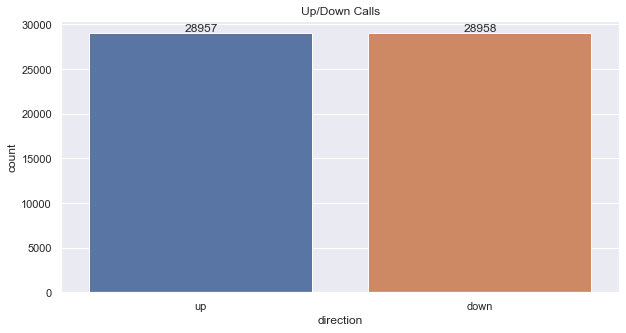

In [52]:
plt1,ax1 = plt.subplots(figsize=(10,5))
ax1 = sb.countplot(df_sim.direction)
ax1.set_title("Up/Down Calls")
for rect in ax1.patches:
    ax1.text(rect.get_x() + rect.get_width()/2, rect.get_height(), rect.get_height(), ha='center', va='bottom')
plt1.show()

Can see the elevator has an almost equal up/down calls in total.

##### Reshaping the data to what we need


In [53]:
df_sim['wait_time']  = np.NaN # create a new column for wait time
df_sim['elevator_id'] = '' # create a new column for elevator id (which elevator arrived)
df_sim["src_floor"] = '' # create a new column for the floor the elevator is coming from

In [59]:
for row in df_sim.itertuples():
    if row.subject == "system":
        forward_search_range = df_sim.iloc[row.Index : row.Index + 100]
        for forward_search_row in forward_search_range.itertuples():
            if (
                row.floor == forward_search_row.floor
                and forward_search_row.action == "door open"
            ):
                result = forward_search_row.time - row.time
                df_sim.loc[row.Index, "wait_time"] = result.seconds
                df_sim.loc[row.Index, "elevator_id"] = forward_search_row.subject
                break
            else:
                continue
        backward_search_range = df_sim.iloc[row.Index :: -1]
        for backward_search_row in backward_search_range.itertuples():
            if (
                backward_search_row.subject == forward_search_row.subject
                and backward_search_row.action == "door open"
            ):
                df_sim.at[row.Index, "src_floor"] = backward_search_row.floor
                break
            else:
                df_sim.at[row.Index, "src_floor"] = row.floor
                continue


In [60]:
df_sim.wait_time.fillna(0,inplace=True)
df_sim.wait_time = df_sim.wait_time.astype(int)

In [61]:
def floors_traveled(x):
    if x.subject == "system":
        result = abs(x.floor - x.src_floor)
        return result
    else:
        return 0


floor_difference = df_sim.apply(floors_traveled, axis=1)
df_sim["floors_traveled"] = floor_difference


In [62]:
# change datafram index to time
df_sim = df_sim.set_index('time')

In [63]:
df_wait_time = df_sim.loc[df_sim['action'] == 'call']
df_wait_time.drop('weight' , axis=1, inplace=True)
df_wait_time

,action,direction,floor,subject,system,wait_time,elevator_id,src_floor,floors_traveled
time,,,,,,,,,
2019-01-01 07:50:53.906554,call,up,0,system,elevator control,0,1,0,0
2019-01-01 07:54:40.829759,call,up,0,system,elevator control,0,2,0,0
2019-01-01 08:01:37.689910,call,up,0,system,elevator control,0,0,0,0
2019-01-01 08:10:29.154320,call,up,0,system,elevator control,0,3,0,0
2019-01-01 08:15:34.082043,call,up,0,system,elevator control,8,2,2,2
...,...,...,...,...,...,...,...,...,...
2019-05-29 21:33:52.172793,call,down,2,system,elevator control,8,1,0,2
2019-05-29 21:38:43.165430,call,down,2,system,elevator control,8,3,0,2
2019-05-29 21:58:30.144980,call,down,15,system,elevator control,60,2,0,15


### Question 1: Is the wait time related to time of the day?

### Question 2: Is the wait time related to floors?